In [1]:
%load_ext autoreload
%autoreload 2

# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [3]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

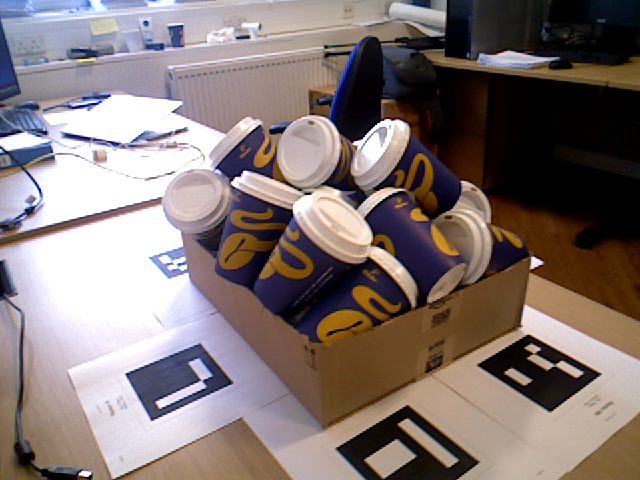

In [4]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "cnos_analysis/crop_proposals/000001.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [5]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

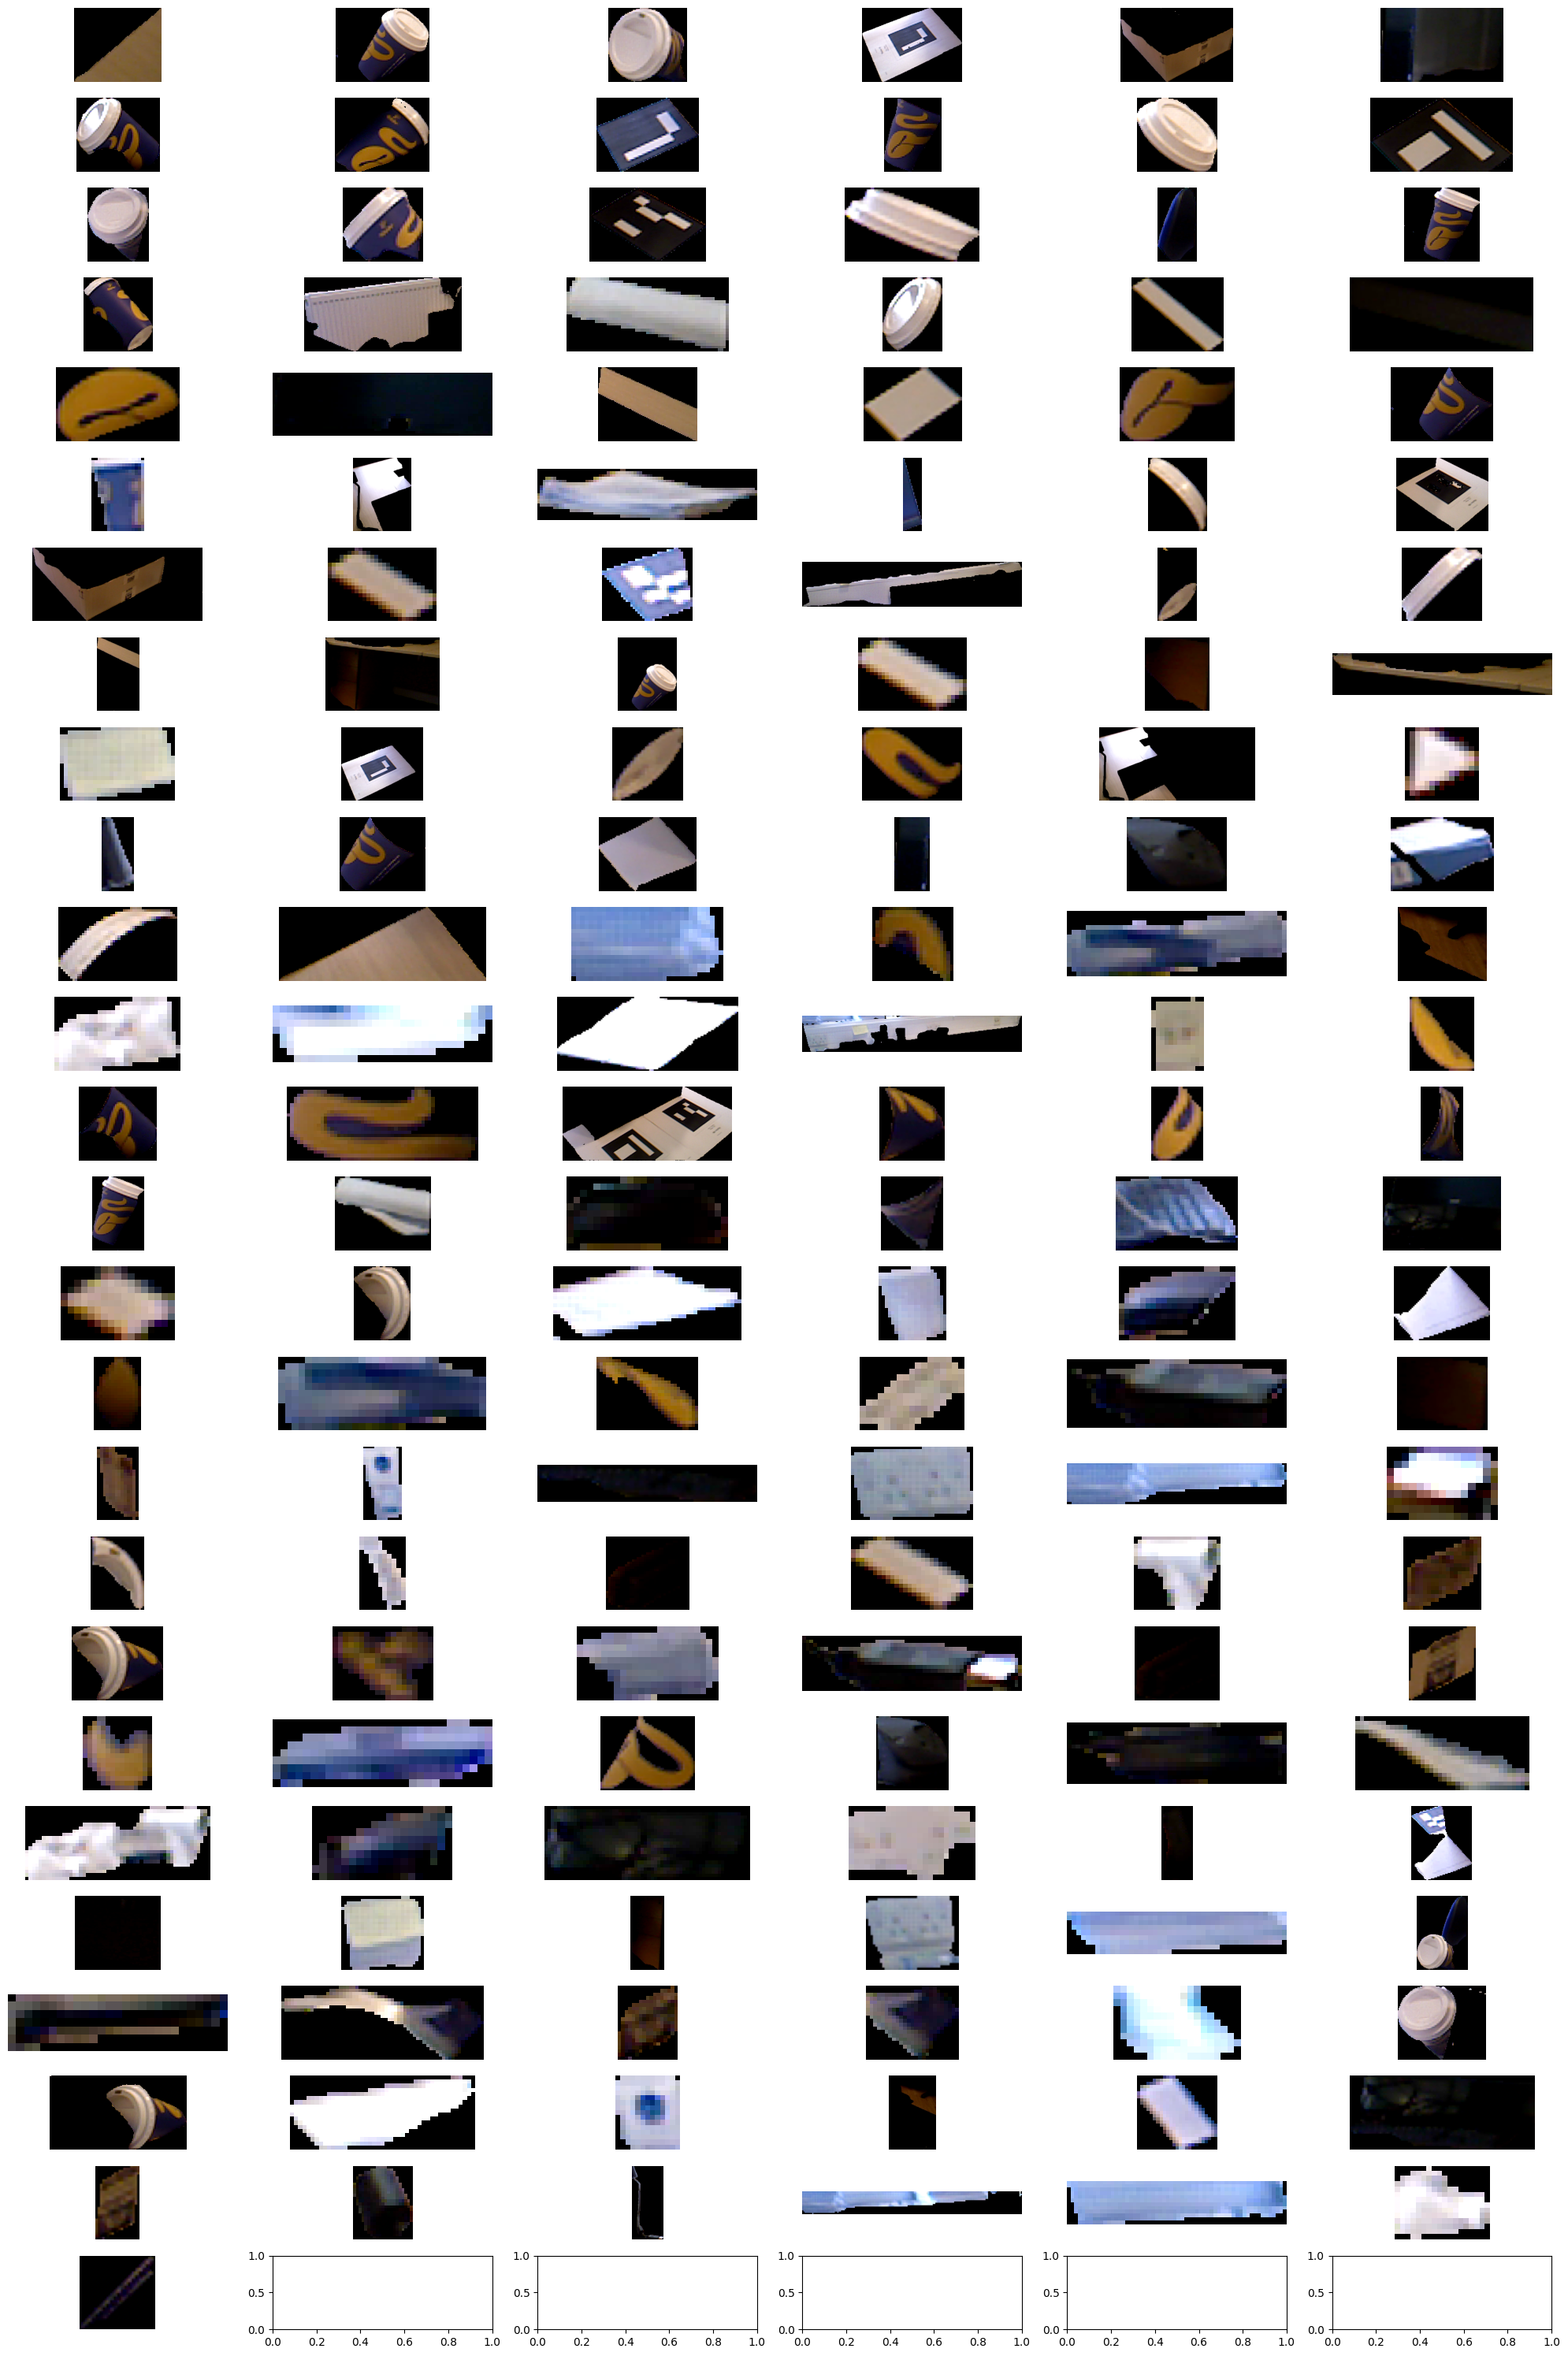

In [6]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [7]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 102 # 125, 102 for background; 2 for foreground
obj_id = 1
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}

# Save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [9]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_1699420/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [29]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [11]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [30]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

INFO:lightning_lite.utilities.seed:Global seed set to 2023
INFO:lightning_lite.utilities.seed:Global seed set to 2023
Loading metaData: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]
Finding nearest rendering close to template poses: 100%|██████████| 2/2 [00:00<00:00, 103.50it/s]


In [31]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

## 2.2. Templates features extraction

In [26]:
import glob
import os

obj_id_2 = 2
real_data_type = "test" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
real_template_path_1 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id:06d}_original" 
real_template_path_2 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
real_template_files_1 = sorted(glob.glob(os.path.join(real_template_path_1, "*.png")), key=os.path.getmtime)
real_template_files_2 = sorted(glob.glob(os.path.join(real_template_path_2, "*.png")), key=os.path.getmtime)
real_template_files = real_template_files_1 
real_num_templates = len(real_template_files)
real_num_templates

162

In [32]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 
syn_num_templates = len(syn_template_files)
syn_num_templates

162

In [49]:
import glob
import os

obj_id_2 = 2

# Load original templates when before putting through dinov2 we also apply transformation.
pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
pyrender_template_files = pyrender_template_files_1 
pyrender_num_templates = len(pyrender_template_files)
pyrender_num_templates

642

In [52]:
from PIL import Image
import numpy as np
# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
real_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in real_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
pyrender_templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3] for template_file in pyrender_template_files]

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [53]:
from src.model.foundpose import resize_and_pad_image
import torchvision.transforms as T
def cnos_templates_feature_extraction(templates, dino_model, num_templates, device):
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

    normalized_templates = [rgb_normalize(template/255.0).float() for template in templates]
    # normalized_crop_rgb = torch.tensor(crop_rgb, dtype=torch.float32).permute(2,0,1)
    print("normalized_templates shape", normalized_templates[0].shape)

    scaled_padded_templates = [resize_and_pad_image(normalized_template, target_max=224)
                            for normalized_template in normalized_templates] # Unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_templates.shape", len(scaled_padded_templates), scaled_padded_templates[0].shape) 

    
    plt.imshow(templates[0]) #, cmap=plt.cm.gray)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    batch_size = 16
    layers_list = list(range(24))
    template_batches = [scaled_padded_templates[i:i+batch_size] for i in range(0, len(scaled_padded_templates), batch_size)]
    patch_features= list()

    for batch in template_batches:
        batch = torch.stack(batch)
        size = batch.shape[0]
        torch.cuda.empty_cache()
        with torch.no_grad(): 
            batch_feature = dino_model.module.get_intermediate_layers(
                batch.to(device), n=layers_list, return_class_token=True
                )[23][1].reshape(size,-1,1024).cpu()
        patch_features.append(batch_feature.to('cpu'))
        del batch_feature
    patch_features = torch.cat(patch_features)
    del dino_model

    return patch_features.squeeze().to("cuda:0")

normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 162 torch.Size([3, 224, 224])


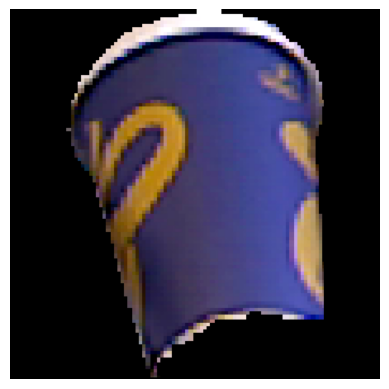

normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 162 torch.Size([3, 224, 224])


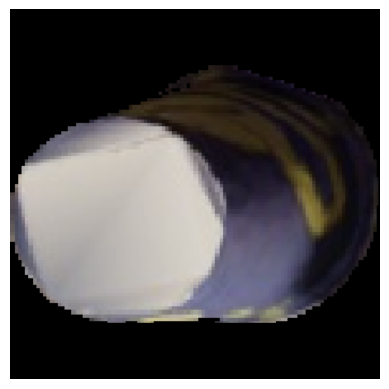

normalized_templates shape torch.Size([3, 400, 350])
scaled_padded_templates.shape 642 torch.Size([3, 224, 224])


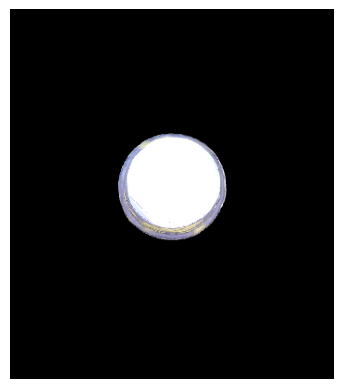

In [54]:
real_ref_features = cnos_templates_feature_extraction(
    templates = real_templates, num_templates = real_num_templates, dino_model = dinov2_vitl14, device = device
    )
syn_ref_features = cnos_templates_feature_extraction(
    templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
    )
pyrender_ref_features = cnos_templates_feature_extraction(
    templates = pyrender_templates, num_templates = pyrender_num_templates, dino_model = dinov2_vitl14, device = device
    )

In [56]:
pyrender_ref_features.shape

torch.Size([642, 1024])

# 3. Extract features from crop and compare with templates

In [39]:
def cnos_crop_feature_extraction(crop_rgb, dino_model, device):
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

    normalized_crop_rgb = rgb_normalize(crop_rgb/255.0).float()
    # normalized_crop_rgb = torch.tensor(crop_rgb, dtype=torch.float32).permute(2,0,1)

    scaled_padded_crop_rgb = resize_and_pad_image(normalized_crop_rgb, target_max=224).unsqueeze(0) # Unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_crop_rgb.shape", scaled_padded_crop_rgb.shape)


    # Extract features from 18th layer of Dinov2 
    layers_list = list(range(24))
    torch.cuda.empty_cache()
    with torch.no_grad(): 
        feature_patches= dino_model.module.get_intermediate_layers(
            scaled_padded_crop_rgb.to(device), n=layers_list, return_class_token=True)[23][1].reshape(-1,1024)
    del dino_model

    return feature_patches

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from src.model.loss import PairwiseSimilarity, Similarity
from torchvision.io import read_image
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

def calculate_similarity(crop_rgb, feature_decriptors, ref_features,templates, metric = metric):
    # get scores per proposal
    scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
    score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
    # get the final confidence score
    score_per_detection = torch.mean(score_per_detection, dim=-1) 
    # Check the confidence scores for the similar templates
    similar_scores = scores[:, similar_template_indices[0].to("cpu")]

    # Display the crop
    plt.imshow(crop_rgb)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    print("top 5 confidence scores", similar_scores)
    print("final average confidence score", score_per_detection)

    width = 50
    height = 50
    fig = plt.figure(figsize=(15, 15))
    columns = 3
    rows = 2

    for i, index in enumerate(similar_template_indices[0]):
        fig.add_subplot(rows, columns, i + 1)
        img = templates[index] # permute(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Top Template {index}')

    plt.tight_layout()
    plt.show()

    return

## 3.1 Normal crop

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])


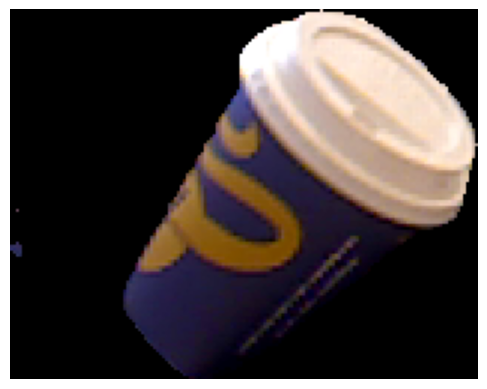

top 5 confidence scores tensor([[0.8776, 0.8751, 0.8613, 0.8536, 0.8531]], device='cuda:0')
final average confidence score tensor([0.8642], device='cuda:0')


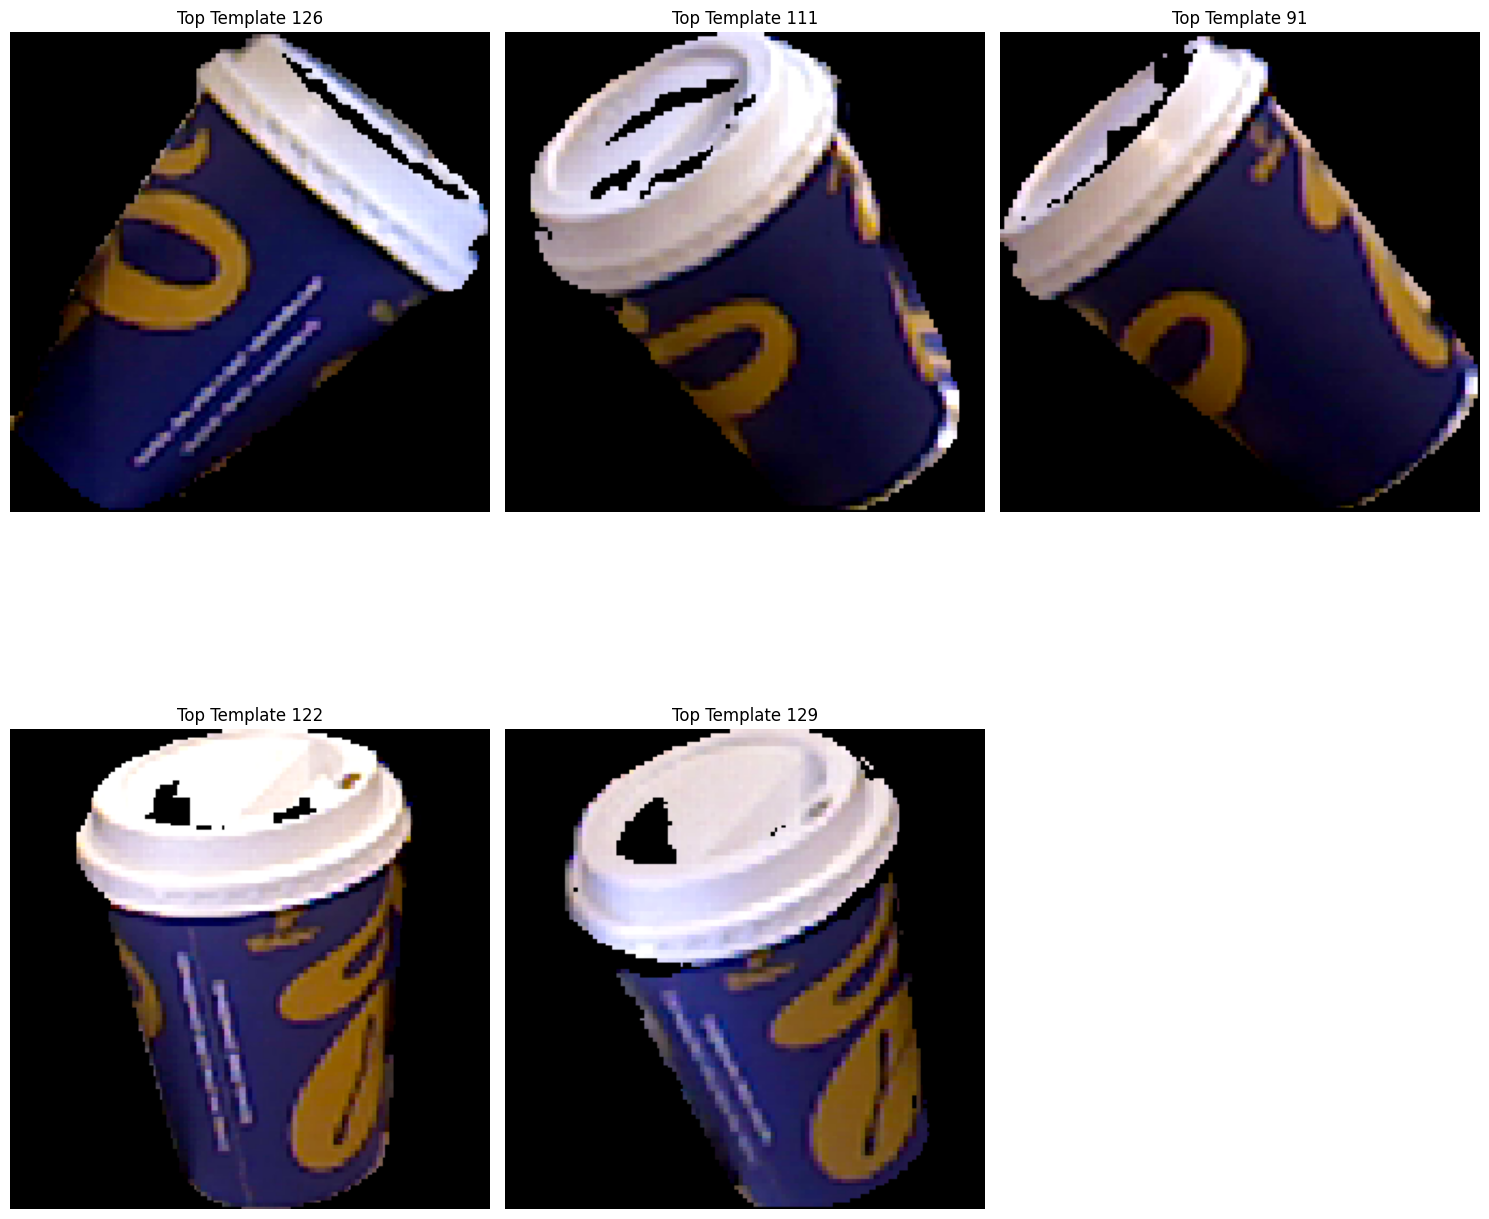

In [58]:
# normal crop
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
normal_features = cnos_crop_feature_extraction(crop_rgb, dinov2_vitl14, device)
calculate_similarity(crop_rgb, normal_features, real_ref_features, real_templates)
# calculate_similarity(crop_rgb, normal_features, syn_ref_features, syn_templates)
# calculate_similarity(crop_rgb, normal_features, pyrender_ref_features, pyrender_templates)

## 3.2 Small crop